<a href="https://colab.research.google.com/github/anniepeacock/DANSAR/blob/devel/Fire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# SAR Application: Fire Extent Detection and Mapping
### I. How to create SAR quicklook images of fire extent?

* Useful Products: Polarimetric Synthetic Aperture Radar (PolSAR) products in the HH and HV polarizations, Pauli Decomposition images, dual-pol coomposites (HH, HV, HH/(HH+HV)), and InSAR coherence products
* Useful Wavelengths: L, S, C
* Instructions to View: Pauli decomposition for quad-pol data or HH/HV, VV/VH for dual-pol images

### II. How to interpret SAR images of fire extent?

The overlay of different polarization channels allows users to visually classify a scene by its backscattering mechanism, such as surface scattering (strong HH and VV return), volume scattering (strong HV return) and double-bounce scattering (strong HH return). RGB or "Red Green Blue" images, have these polarization channels encoded into different color channels, and the resulting color image can be employed to interpret physical information on the ground.

To identify burnt areas, compare the band ratios and Pauli Decomposition images from before and after the fire event, using the same scale to facilitate comparison. Area impacted by fire should show increase HH component (bare ground) and lower vegetation component (HV). In Pauli RGB images, areas dominated by green (HV) intensity are typically vegetated areas. Areas dominated by shades of pink (HH+HV) intensity are typically inundated forests, vegetated fields, or urban areas. Black and dark grey areas are usually smooth surfaces (roads, open water, smooth bare ground) where there is little radar backscatter.

Radar coherence images measure how well the phase signal is preserved between SAR acquisitions and can provide another method to detect areas of change. For a fire application, areas of lower coherence should correspond with the fire scar extent since changes in vegetation and other associated damage from the fire will cause decorrelation. For interpreting coherence products, compare image pairs with increasing temporal separation, until after a certain time between acquisitions when the entire image is decorrelated.

These grayscale coherence correlation products range from a scale of 0 to 1, where areas of decorrelation or disturbance approach 0. In a coherence map, darker areas have lower coherence or have decorrelated between acquisitions, as such, close to black areas are normally open water bodies that decorrelate the fastest, dark gray areas are regions decorrelated due to fire, and mid-gray and white have higher coherence or experienced less disturbance.

# 2017 La Tuna Fire Los Angeles, California

This Jupyter Notebook explores UAVSAR data over the 2017 La Tuna Fire in Los Angeles, California. Click on the underlined titles below to navigate to their section. The content of this notebook is as follows:

0. [Import Python Packages and Authenticate Notebook and data ](#s1)
1. [UAVSAR RGB Composite of La Tuna Fire](#s2)
2. [Create and Plot HV Transects](#s3)
3. [Time Series (dB)](#s4)



<a name="s1"></a>
## Running the Notebook
- This Notebook has both "text" and "code" cells. The text cells have text descriptions about running the notebooks and data interpretation.
- Code cells are a light gray and a "play" button appears in the upper left corner when your mouse is hovered over the cell.
- To run the content in the code cells, **select the play button** in the upper left corner of each code cell or **press shift-enter**. 
- Code cells that are required for the notebook to run without errors are marked numerically with <font color='red'> Run cell below </font> 

### Python Packages:
This routine uses the following python libraries. Some are already included in the Google Colab environment and others are installed in the cell below before imported. Downloading new python packages to this environment may take a few minutes to complete.

<font color='red'> 1. Run cell below </font> 

In [4]:
## The packages will take around a minute to install
!pip install rasterio --quiet
!pip install rasterstats --quiet
!pip install --upgrade geopandas --quiet 
!pip install rioxarray --quiet
!pip install earthpy --quiet

import earthpy.plot as ep
import rasterio as rio
import rasterio.plot
from rasterio.plot import show
import rasterstats as rs
from rasterio.plot import plotting_extent
from rasterio.mask import mask
from rasterio.merge import merge
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

import rioxarray #as rxr ## gdal Readasarray equivalent

import geopandas as gpd
import pandas as pd
from geopandas import GeoDataFrame

from shapely.geometry import Point
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks
import plotly.graph_objects as go

import numpy as np
import numpy.ma as ma
from pathlib import Path
from skimage.measure import profile_line
import math

#stats
from scipy.stats import gaussian_kde
import seaborn as sns
from sklearn.metrics import r2_score

     |████████████████████████████████| 20.9 MB 1.4 MB/s 
     |████████████████████████████████| 16.6 MB 33.7 MB/s 
     |████████████████████████████████| 139 kB 63.9 MB/s 
     |████████████████████████████████| 1.1 MB 33.6 MB/s 
     |████████████████████████████████| 7.8 MB 55.5 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 


<a name="s2"></a>
# 1. Download Files

# UAVSAR RGB Composite of La Tuna Fire
The RGB UAVSAR images below show the September 2017 La Tuna Fire in the Verdugo Mountains, Los Angeles, California. The UAVSAR flightline SanAnd_08525 was acquired October 23, 2014 (Pre-fire) and November 02, 2017 (Post-fire). The fire perimeter extent is overlaid in red.

(Pre-Fire Top) 2014 Product Page: 
https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_14158_003_141023_L090_CX_01#data & SanAnd_26526

(Post-Fire Bottom) 2017 Product Page: 
https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_17122_003_171102_L090_CX_01#data & SanAnd_26526


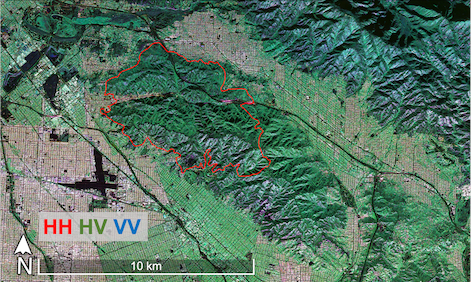

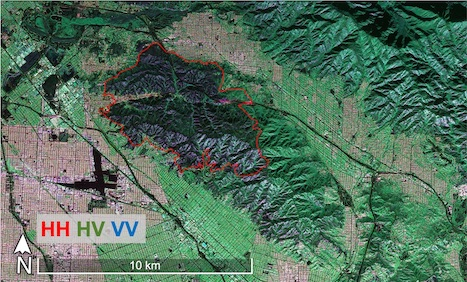

# USGS BAER Severity Products
BAER Products originally downloaded from: https://burnseverity.cr.usgs.gov/viewer/?product=BAER

Fire perimeter downloaded from the NIFC: https://data-nifc.opendata.arcgis.com/datasets/historic-perimeters-2017/explore

The "not burned" geojson of the Verdugo Mountains was hand traced.

To directly compare, the UAVSAR HV log ratio and the BAER fire severity products, we will need to directly align the two datasets. This can be achieved by resampling the UAVSAR data from 6 meter to 30 meter resolution, to make BAER.

In [5]:
## UAVSAR Geotiffs
# These are merged UAVSAR lines SanAnd_08525 & SanAnd_26526, masked for low and high local incidence angles
# 6 meter pixel size
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/6m.tif  --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/30m.tif  --quiet

!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/latuna_perimeter.geojson --quiet

<a name="s3"></a>
## 2. Read in Files & Mask Burned and Not Burned Areas
Use rasterio to open UAVSAR Data and geopandas to read in perimeter geojsons. Create separate masks of "burned" and "not burned" areas using geojsons of the fire perimeter and the unburned portion of the Verdugo Mountains.

Data Stack (6 meter and 30 meter resolutions):
1. Band1 = HV 2014
2. Band2 = HV 2017
3. Band3 = dNBR
4. Band4 = Fire Perimeter
5. Band5 = Unburned area of Verdugo Mountains

In [51]:
## 30 meters
stack = rio.open('30m.tif')
stack = stack.read((1,2,3,4,5))

# Read in stack's bands
hv2014 = stack[0, 0:, 0:]
hv2017 = stack[1, 0:, 0:]
dnbr = stack[2, 0:, 0:]
perimeter = stack[3, 0:, 0:]
verdugos = stack[4, 0:, 0:]

# stack = rio.open('6m.tif')
# stack = stack.read((1,2,3,4,5))

# # Read in stack's bands
# hv2014 = stack[0, 0:, 0:]
# hv2017 = stack[1, 0:, 0:]
# dnbr = stack[2, 0:, 0:]
# perimeter = stack[3, 0:, 0:]
# verdugos = stack[4, 0:, 0:]

Plot UAVSAR HV Pre and Post Fire

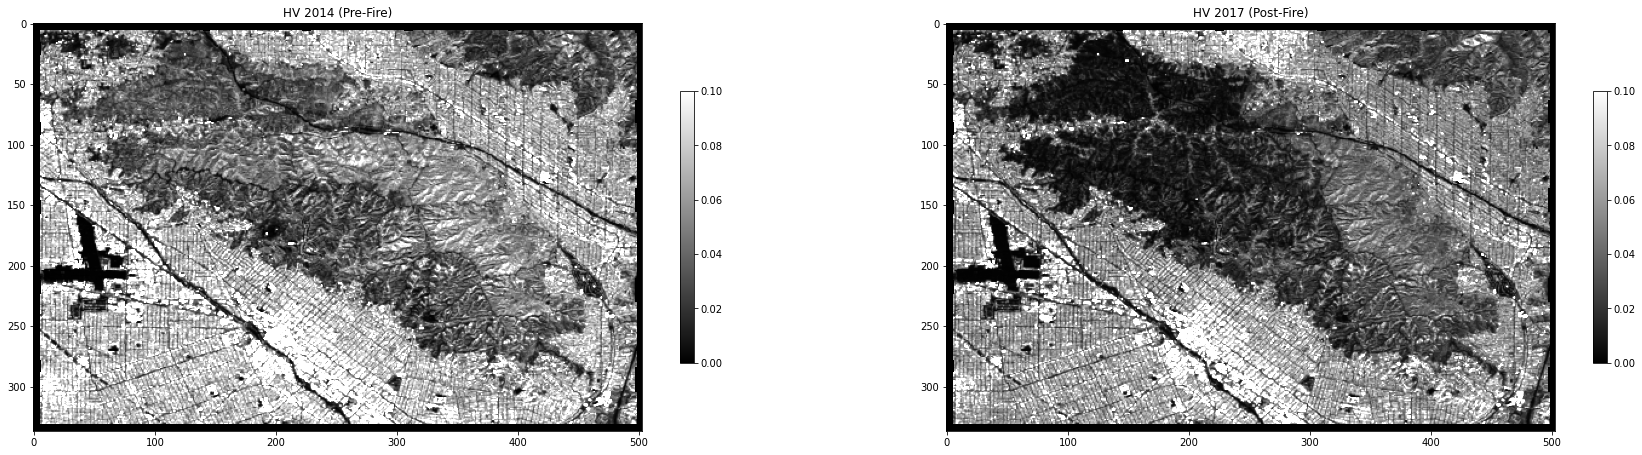

In [52]:
# Plot 2014 and 2017
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(30,10))

vmin = 0
vmax = 0.1

cmap = "gray"
plot = ax1.imshow(hv2014.squeeze(), vmin=vmin, vmax=vmax, cmap=cmap)
ax1.set_title('HV 2014 (Pre-Fire)')
fig.colorbar(plot, ax=ax1, shrink=0.5)

plot = ax2.imshow(hv2017.squeeze(), vmin=vmin, vmax=vmax, cmap=cmap)
ax2.set_title('HV 2017 (Post-Fire)')
fig.colorbar(plot, ax=ax2, shrink=0.5)

<a name="s3"></a>
## 3. Calculate the HV Log Ratio
Below is a transect over the Verdugo mountains, spanning burned and unburned regions of the mountain range after the September 2017 La Tuna Fire. UAVSAR's HV polarization is used due to HV's sensitivity to vegetation change and transects from images pre and post fire can be uesd compare changes in HV backscatter values between areas burnt in the fire and unburnt areas. Burnt areas should have decreased HV backscatter.



Calculate and plot the HV/HV log ratio for pre and post fire UAVSAR acquisitions. 

Source: pg 116 https://gis1.servirglobal.net/TrainingMaterials/SAR/SARHB_FullRes.pdf </font> 



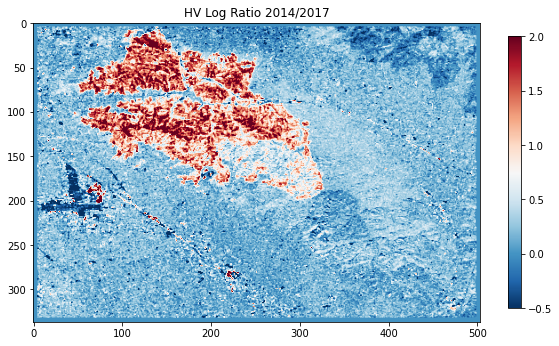

In [53]:
# Find the HV log ratio between 2014 and 2017 UAVSAR acquisitions
HV_log_2014_2017 = np.log(np.divide(hv2014, hv2017))

# Plot
fig,(ax1) = plt.subplots(1,1, figsize=(10,10))

vmin = -0.5
vmax = 2

cmap = "RdBu_r"
plot = ax1.imshow(HV_log_2014_2017, vmin=vmin, vmax=vmax, cmap=cmap)
ax1.set_title('HV Log Ratio 2014/2017')
fig.colorbar(plot, ax=ax1, shrink=0.5)

<a name="s3"></a>
## 4. UAVSAR & dNBR Comparison

Plot UAVSAR HV Log Ratio next to BAER's (Burned Area Emergency Response) dNBR (Differenced Normalized Burn Ratio) released fire severity product. The stripes in the dNBR is due to issues with Landsat 7. 


For dNBR, see one clear area of high severity, while UAVSAR seems to show two areas of high severity. There's one clear area of disagreemnt in North (UAVSAR high intensity) and East (dNBR high intensity)

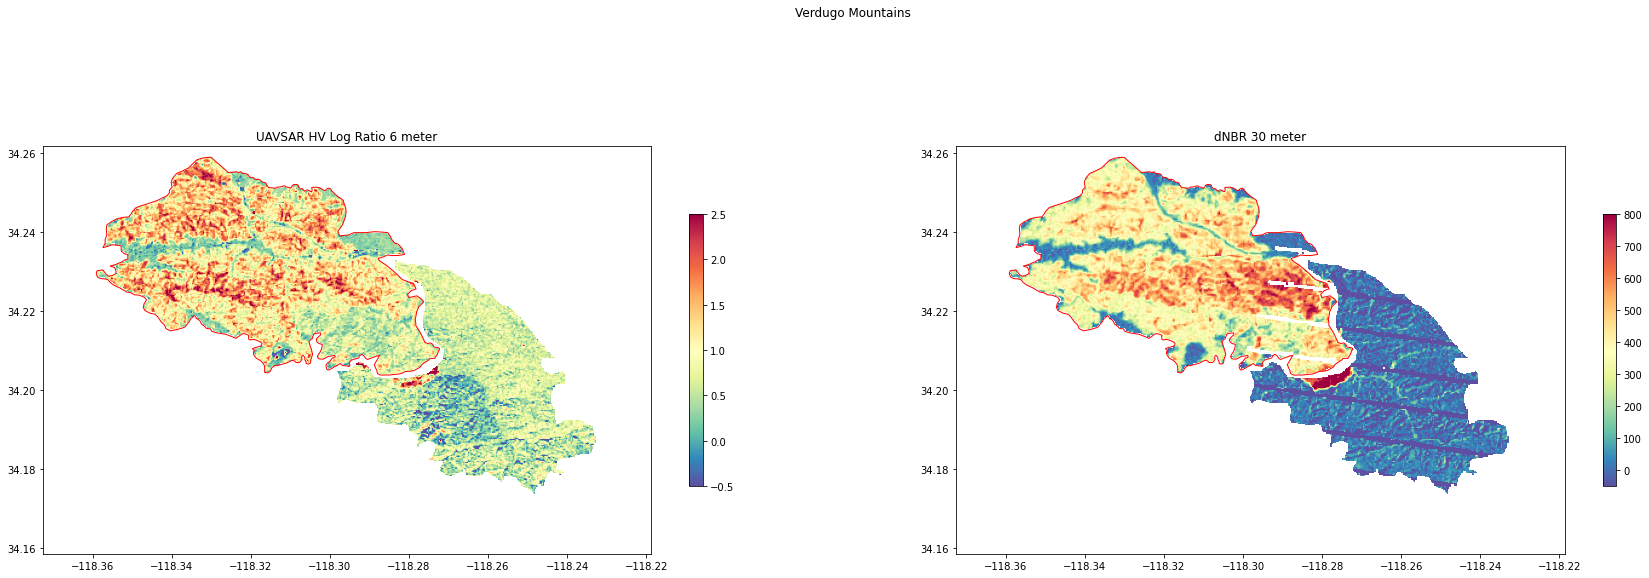

In [54]:
#@title Plot UAVSAR & dNBR

### BREAK UP CELL 
# 1) Find threshold and plot histogram 
# 2) Masking the map
# 3) Prep to overlay perimeter
# 4) Making the map

fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(30,10))

# Add fire perimeters
# Read in fire perimeter
with rio.open('6m.tif') as subset_src: #getting reference extent
    subset_extent = plotting_extent(subset_src)
    trans = subset_src.transform
fire_perimeter = gpd.read_file('latuna_perimeter.geojson')
fire_perimeter = fire_perimeter["geometry"]
fire_boundary = fire_perimeter.to_crs(subset_src.crs)
fire_boundary.plot(edgecolor='red', facecolor='none', ax=ax1)
fire_boundary.plot(edgecolor='red', facecolor='none', ax=ax2)

# Add general map title
fig.suptitle('Verdugo Mountains')
# Map vis parameters
cmap = "Spectral_r"
vmin = -0.5
vmax = 2.5
args = dict(vmin=vmin, vmax=vmax, cmap=cmap, extent=subset_extent)

HV_log_2014_2017_burned = np.multiply(HV_log_2014_2017, perimeter)
HV_log_2014_2017_burned[HV_log_2014_2017_burned==0] = np.nan
HV_log_2014_2017_notburned = np.multiply(HV_log_2014_2017, verdugos)
HV_log_2014_2017_notburned[HV_log_2014_2017_notburned==0] = np.nan

dnbr_burned = np.multiply(dnbr, perimeter)
dnbr_burned[dnbr_burned==-9999] = np.nan
dnbr_burned[dnbr_burned==0] = np.nan
dnbr_notburned = np.multiply(dnbr, verdugos)
dnbr_notburned[dnbr_notburned==-9999] = np.nan
dnbr_notburned[dnbr_notburned==0] = np.nan

# Plot UAVSAR
ax1.imshow(HV_log_2014_2017_burned.squeeze(), **args)
plot = ax1.imshow(HV_log_2014_2017_notburned.squeeze(), **args)
ax1.set_title("UAVSAR HV Log Ratio 6 meter")
fig.colorbar(plot, ax=ax1, shrink=0.5)

# Plot dNBR
ax2.imshow(dnbr_burned.squeeze(), vmin=-50, vmax=800, cmap=cmap, extent=subset_extent)
plot = ax2.imshow(dnbr_notburned.squeeze(), vmin=-50, vmax=800, cmap=cmap, extent=subset_extent)
ax2.set_title("dNBR 30 meter")
fig.colorbar(plot, ax=ax2, shrink=0.5)

Plot UAVSAR and dNBR histograms, and find thresholds to determine low, medium, and high fire severity for each dataset (UAVSAR and dNBR) using area under the curve. 

The dNBR fire severity product was derived from Landsat 8 and Landsat 7 data.  Pre-fire and post-fire scenes are analyzed to create a differenced Normalized Burn Ratio (dNBR) image. The dNBR image portrays the variation of burn severity within the fire. The pre- and post-fire Landsat images are terrain corrected and corrected to Top of Atmosphere reflectance. 

The Normalized Burn Ratio (NBR) is computed for each date of imagery (Landsat 8 bands) using the following formula: 

	NBR = (Band 5(NIR) - Band 7(SWIR) / (Band 5 + Band 7)

The Differenced NBR is computed to determine severity by subtracting the post-fire NBR from the pre-fire NBR:

	dNBR = (PreNBR - PostNBR)

The BARC products are a generalization of the raw dNBR dataset. Both BARC products have been resampled to unsigned 8-bit images and are easily viewed and adjusted within ArcGIS.

The classes represented on the BARC products are created with thresholds chosen by an analyst at USGS EROS. The thresholds used on this particular fire are:
   
	Unchanged:  -275 to 110
	Low:		115 to 280
	Moderate:   285 to 670
	High:	   675 10000
	No Data/Clouds 

dNBR thresholds:

	115
	285
	675




UAVSAR
The threshold for 0.95 percentile under the curve is: 1.1
The threshold for 0.11 percentile under the curve is: 0.3
The threshold for 0.24 percentile under the curve is: 0.6
The threshold for 0.97 percentile under the curve is: 2.2


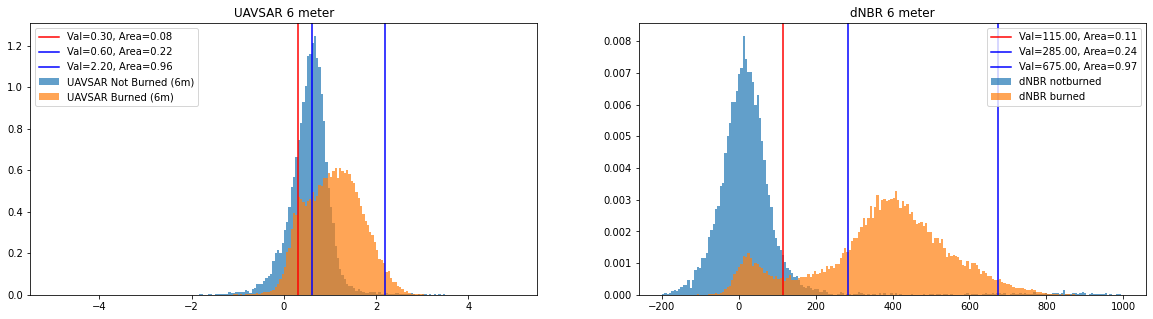

In [55]:
#@title UAVSAR & dNBR Histograms

# Function to find the area under the curve & plot a line
def area_under_curve(axes, bins, value, counts, color):
  # Find bin corresponding to percent value
  array = np.asarray(value)
  # Return indices of bins of array value
  index = np.digitize(array, bins) - 1
  # Calculate area under hist after value
  bin_width = np.diff(bins)[0]
  area = sum(bin_width * counts[:index])
  # Add area line
  axes.axvline(value, color=color, label=f"Val={value:.2f}, Area={area:.2f}")
  axes.legend()

# Function to find the index for a specific area under the histogram's curve
def area(bins, height, value):
  # Find width of histogram bins
  bin_width = np.diff(bins)[0]
  # Get the area of each bin
  area = height * bin_width
  # Find the cumulative sum of the bins
  cumsum = np.cumsum(area)
  # Find the bin index where the cumulative area equals the input value
  array = np.asarray(value)
  index = np.digitize(array, cumsum)
  print("The threshold for " + str(value) + " percentile under the curve is: " + str(bins[index]))

fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(20,5))

######################### Histograms ######################### 
########## UAVSAR 6 meter#############
n_notburned, bins_notburned, patches_notburned = ax1.hist(HV_log_2014_2017_notburned.flatten(), range = [-5, 5], bins=200, alpha=0.7, density=True,label='UAVSAR Not Burned (6m)')
n_burned, bins_burned, patches_burned = ax1.hist(HV_log_2014_2017_burned.flatten(), bins=200, range = [-5, 5], alpha=0.7, density=True, label='UAVSAR Burned (6m)')
ax1.set_title("UAVSAR 6 meter")

print("UAVSAR")
# Find threshold for top 5% of the not burned area
area(bins_notburned, n_notburned, 0.95)
# Find threshold for top 10% of the not burned area
area(bins_burned, n_burned, 0.11)
area(bins_burned, n_burned, 0.24)
area(bins_burned, n_burned, 0.97)

# Plot a line showing threshold for not burned 0.95
#area_under_curve(ax1, bins_notburned, 1.305, n_notburned, color="r")
# Plot a line showing threshold for burned 0.95
area_under_curve(ax1, bins_burned, 0.3, n_burned, color="r")
area_under_curve(ax1, bins_burned, 0.6, n_burned, color="b")
area_under_curve(ax1, bins_burned, 2.2, n_burned, color="b")

########## dNBR 6 meter#############
n_notburned, bins_notburned, patches_notburned = ax2.hist(dnbr_notburned.flatten(), bins=200, range = [-200, 1000], alpha=0.7, density=True,label="dNBR notburned")
n_burned, bins_burned, patches_burned = ax2.hist(dnbr_burned.flatten(), bins=200, alpha=0.7, range = [-200, 1000], density=True,label="dNBR burned")
ax2.set_title("dNBR 6 meter")

# print("dNBR")
# # Find threshold for top 5% of the not burned area
# area(bins_notburned, n_notburned, 0.95)
# # Find threshold for top 10% of the burned area
# area(bins_burned, n_burned, 0.90)

# dNBR low burn threshold
area_under_curve(ax2, bins_burned, 115, n_burned, color="r")
# dNBR moderate burn threshold
area_under_curve(ax2, bins_burned, 285, n_burned, color="b")
# dNBR high burn threshold
area_under_curve(ax2, bins_burned, 675, n_burned, color="b")

Text(0.5, 1.0, 'Verdugo Moutains Not Burned: HV Log Ratio 2014/2017 vs dNBR')

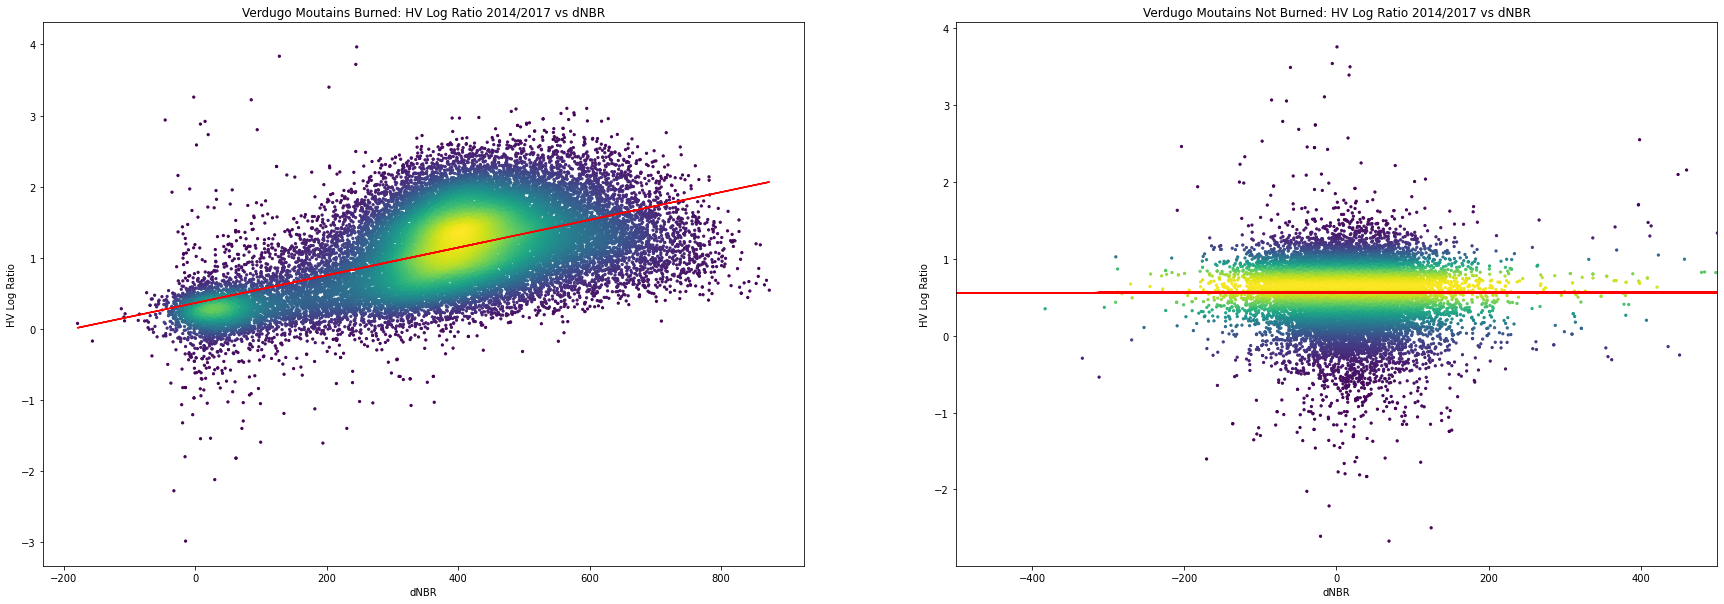

In [56]:
#@title UAVSAR & dNBR Scatterplots

fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(30,10))

y = HV_log_2014_2017_burned
x = dnbr_burned
y = y[~np.isnan(x)]
x = x[~np.isnan(x)]
# x = np.random.choice(x, 30000, replace=False)
# y = np.random.choice(y, 30000, replace=False)

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax1.scatter(x, y, c=z, s=5)

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)
ax1.plot(x, m*x+b, color='red')
ax1.set_xlabel('dNBR')
ax1.set_ylabel('HV Log Ratio')
ax1.set_title('Verdugo Moutains Burned: HV Log Ratio 2014/2017 vs dNBR')
# ax1.annotate("R-squared = {:.3f}".format(r2_score(x, y)), (0,3))
# ax1.imshow()

y = HV_log_2014_2017_notburned
x = dnbr_notburned
y = y[~np.isnan(x)]
x = x[~np.isnan(x)]

# x = np.random.choice(x, 30000, replace=False)
# y = np.random.choice(y, 30000, replace=False)
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax2.scatter(x, y, c=z, s =5)
ax2.set_xlim([-500, 500])

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)
ax2.plot(x, m*x+b, color='red')
ax2.set_xlabel('dNBR')
ax2.set_ylabel('HV Log Ratio')
ax2.set_title('Verdugo Moutains Not Burned: HV Log Ratio 2014/2017 vs dNBR')
# ax2.annotate("R-squared = {:.3f}".format(r2_score(x, y)), (0,3))
# ax2.imshow()


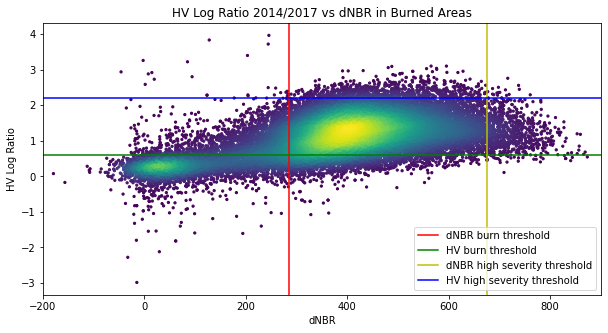

In [171]:
#@title UAVSAR & dNBR Scatterplots Thresholds
fig, ax = plt.subplots(figsize=(10, 5))

HV_log_2014_2017_burned = np.multiply(HV_log_2014_2017, perimeter)
HV_log_2014_2017_burned[HV_log_2014_2017_burned==0] = np.nan

y = HV_log_2014_2017_burned
x = dnbr_burned
y = y[~np.isnan(x)]
x = x[~np.isnan(x)]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
plt.scatter(x, y, c=z, s=5)

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)
# plt.plot(x, m*x+b, color='red')
plt.axvline(x = 285, color = 'r', label = 'dNBR burn threshold')
plt.axhline(y = 0.6, color = 'g', label = 'HV burn threshold')
plt.axvline(x = 675, color = 'y', label = 'dNBR high severity threshold')
plt.axhline(y = 2.2, color = 'b', label = 'HV high severity threshold')
plt.legend()

plt.xlabel('dNBR')
plt.ylabel('HV Log Ratio')
plt.title('HV Log Ratio 2014/2017 vs dNBR in Burned Areas')
plt.xlim([-200, 900])
#ax.annotate("Pearson's R = {:.3f}".format(x.corr(y)), (0,3)) ## r2_score large negative result
# https://realpython.com/numpy-scipy-pandas-correlation-python/
plt.show()


### Make same plot, looking specifically at high fire severity for UAVSAR & dNBR
# uncertainties - UAVSAR high, dNBR moderate & dNBR high, UAVSAR low
# map these & map interpretation with google earth 


# New plot with all of the Verdugo Mountains

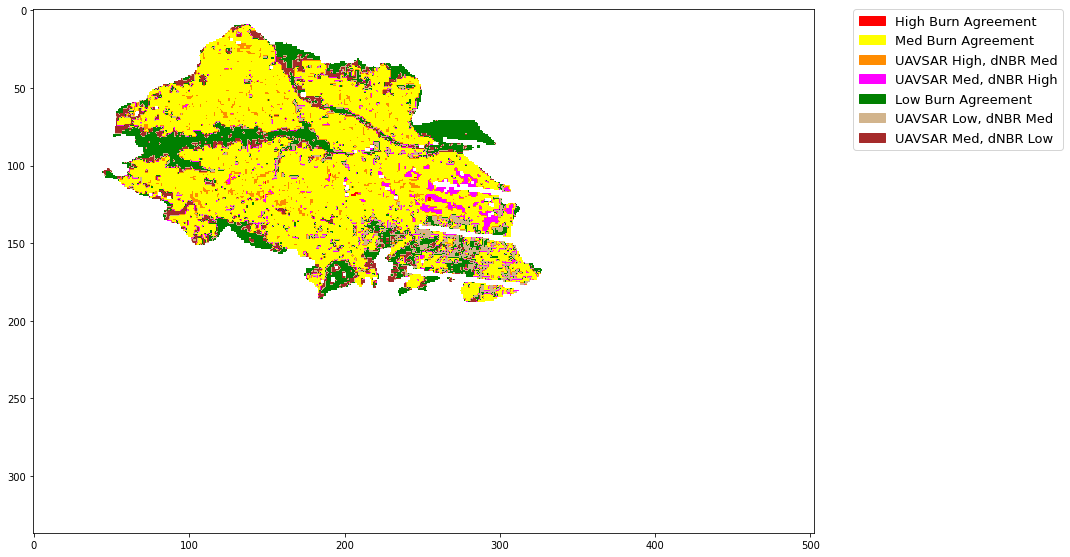

In [249]:
#@title Reclassify with Thresholds and Plot Reclassified Data
# Separate into 4 classes depending on threshold
burn_thresh_dnbr = 285
burn_thresh_hv = 0.6
severity_thresh_dnbr = 675
severity_thresh_hv = 2.2

HV_log_2014_2017_burned = np.multiply(HV_log_2014_2017, perimeter)
HV_log_2014_2017_burned[HV_log_2014_2017_burned==0] = np.nan

hv = HV_log_2014_2017_burned
dnbr = dnbr_burned
hv_reclass = HV_log_2014_2017_burned

# High Burn UAVSAR, Med Burn dNBR
hv_reclass[np.where((hv >= severity_thresh_hv) & ((dnbr <= severity_thresh_dnbr) & (dnbr >= burn_thresh_dnbr)))] = 30

# High Burn UAVSAR, High Burn dNBR
hv_reclass[np.where((hv >= severity_thresh_hv) & (dnbr >= severity_thresh_dnbr))] = 10
# Med Burn UAVSAR, Med Burn dNBR
hv_reclass[np.where(((hv <= severity_thresh_hv) & (hv >= burn_thresh_hv)) & ((dnbr <= severity_thresh_dnbr) & (dnbr >= burn_thresh_dnbr)))] = 20

# # High Burn UAVSAR, Med Burn dNBR
# hv_reclass[np.where((hv >= severity_thresh_hv) & ((dnbr <= severity_thresh_dnbr) & (dnbr >= burn_thresh_dnbr)))] = 30
# Med Burn UAVSAR, High Burn dNBR
hv_reclass[np.where(((hv <= severity_thresh_hv) & (hv >= burn_thresh_hv)) & (dnbr >= severity_thresh_dnbr))] = 40

# Low Burned Agreement: Less than HV & dNBR Threshold
hv_reclass[np.where((hv <= burn_thresh_hv) & (dnbr <= burn_thresh_dnbr))] = 50
# Low Burn UAVSAR, Med Burn dNBR
hv_reclass[np.where((hv <= burn_thresh_hv) & ((dnbr <= severity_thresh_dnbr) & (dnbr >= burn_thresh_dnbr)))] = 60
# Med Burn UAVSAR, Low Burn dNBR
hv_reclass[np.where((dnbr <= burn_thresh_dnbr) & ((hv <= severity_thresh_hv) & (hv >= burn_thresh_hv)))] = 70

# Remaining scenarios ignored
hv_reclass[np.where(hv_reclass < 10)] = np.nan

# Define the colors you want
cmap = ListedColormap(["red", "yellow", "darkorange", "magenta", "green", "tan", "brown"])

# Define a normalization from values -> colors
norm = colors.BoundaryNorm([0, 2, 10, 20, 30], 5)

f, ax = plt.subplots(figsize=(15, 15))
im = ax.imshow(hv_reclass, cmap = cmap)
ep.draw_legend(im, titles=["High Burn Agreement","Med Burn Agreement", "UAVSAR High, dNBR Med", "UAVSAR Med, dNBR High", "Low Burn Agreement", "UAVSAR Low, dNBR Med", "UAVSAR Med, dNBR Low"],
               classes=[10, 20, 30, 40, 50, 60, 70])

plt.tight_layout()


# with rasterio.open('reclassified.tif', 'w', **profile) as dst:
#   dst.write(hv_reclass.squeeze().astype(rasterio.float64), 1)

## Data Download
UAVSAR Download: https://uavsar.jpl.nasa.gov/cgi-bin/data.p

ASF: https://search.asf.alaska.edu/#/

## Other Resources
NISAR Fire Applications White Paper: https://nisar.jpl.nasa.gov/system/documents/files/13_NISAR_Applications_Fire_Management1.pdf

ESA Document on Polarimetric Decompositions: https://earth.esa.int/documents/653194/656796/Polarimetric_Decompositions.pdf

Polarimetry: https://nisar.jpl.nasa.gov/mission/get-to-know-sar/polarimetry/

## References
“La Tuna Fire, City's Biggest by Acreage, Now 80% Contained, Officials Say.” Los Angeles Times, Los Angeles Times, 6 Sept. 2017, www.latimes.com/local/lanow/la-me-ln-verdugo-fire-containment-20170905-story.html.

Ban, Y. et al. (2020) Near Real-Time Wildfire Progression Monitoring with Sentinel-1 SAR Time Series and Deep Learning. Nature Scientific Reports, 10 (1322).

California EPA (2021, January 8) Governor’s task force outlines actions to reduce wildfire rish, improve health of forests and wildlands. Accessed February 1, 2021.

Czuchlewski, K.R. and Weissel, J. K. (2005) Synthetic aperture radar (SAR)-based mapping of wildfire burn severity and recovery. Proceedings: 2005 IEEE International Geoscience and Remote Sensing Symposium.

Jung, J., et al. (2018) Damage-Mapping Algorithm Based on Coherence Model Using Multitemporal Polarimetric-Interferometric SAR Data. IEEE Transactions on Geoscience and Remote Sensing 56, 1520–1532.

NASA EarthData (2020, April 16) What is synthetic aperture radar? Accessed February 1, 2021.

NASA Jet Propulsion Laboratory (2021) What is UAVSAR? Accessed February 1, 2021.

NASA Jet Propulsion Laboratory (2020, September 15) NASA Takes Flight to Study California’s Wildfire Burn Areas. Accessed February 1, 2021.

Parker, J., Donnellan, A., & Glasscoe, M. (2021) Survey of Transverse Range Fire Scars in Ten Years of UAVSAR Polarimetry. Wiley.

Rains C. (2019) Detection of Fire Burn Scars by UAVSAR: Immediate, Short-term, and Multi-year Observations and Applications. NASA presentation.

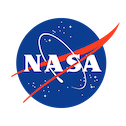

The research was carried out at the Jet Propulsion Laboratory, California Institute of Technology, under a contract with the National Aeronautics and Space Administration (80NM0018D0004)

© 2021. California Institute of Technology. Government sponsorship acknowledged. 